# Housing Price Regression Model

### 2.1 Loading Libraries & Data

In [1]:
# Importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, Lasso, LassoCV, 
Ridge, RidgeCV, ElasticNet, ElasticNetCV)
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import scipy
import scipy.cluster.hierarchy as sch
import scipy.stats as ss

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Load dataset
df_combine = pd.read_csv('../Project_2/datasets/df_combine_cleaned.csv', 
                         index_col=[0,1], skipinitialspace=True)

### 2.2 Feature Engineering

**Price Per Square Foot**

Intuitively, there is a strong correlation between price and size of a property. Based on the heatmap below, we confirm this relationship given that `Gr Liv Area` is the second most correlated with `SalePrice`, with a correlation factor above 0.5. 

Hence to aid in our analysis we would add a feature that calculates price per square foot by dividing `SalePrice` and `Gr Liv Area`, so that the impact to price of other features can more clearly seen after reducing the size dimension that is most impactful to price.

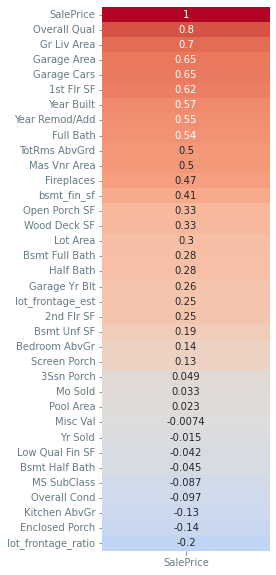

In [3]:
#Area correlation
plt.figure(figsize=(3,10))
#plt.rcParams['figure.constrained_layout.use'] = True
plt.style.use('Solarize_Light2')
plt.yticks(rotation = 45)
g = sns.heatmap(df_combine.loc[('train')].corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
                , cmap='coolwarm', center=0, annot=True, cbar=False)
#g.set_xticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
#g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)

In [4]:
def price_plot_area(df):
    '''Calculates price per square foot for plot area'''
    df['price_psf'] = df['SalePrice'] / df['Gr Liv Area']
price_plot_area(df_combine)

**Calculating Age**

The age since the property was built, remodelled and garage built would be calculated by finding the difference between the three events and `Yr Sold`.

For properties with no garage, the data was initially `NaN`. We would follow the data documentation logic of `Year Remod/Add'`, which is if there is no remodeling, the year would be the same as year of construction. Hence we assign the same age of the property `yr_since_built` to the age of the garage `yr_since_garage`

In [5]:
def age_at_sale(df):
    '''Calculates ages of property, remodelling at point of sale. For some'''
    df['yr_since_built'] = df['Yr Sold'] - df['Year Built']
    df['yr_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
age_at_sale(df_combine)

In [6]:
# Calculate difference between 'Year Built' and 'Garage Yr Blt', and filter for properties with garage.
# The descriptive stats below show little difference between 
df_combine.loc[(df_combine['Garage Yr Blt']==0),'yr_since_garage'] = \
    df_combine['yr_since_built']
    
df_combine.loc[(df_combine['Garage Yr Blt']!=0),'yr_since_garage'] = \
    df_combine['Yr Sold'] - df_combine['Garage Yr Blt']


**Sum Porch Area**

There are 5 columns that pertains to the area of types of porches. I will sum the 5 columns into porch area, and convert each column into boolean logic, where `True`, the property has this type of porch.

In [7]:
def sum_porch_area(df):
    '''Sums porch area of various types and convert column values to binary'''
    porch = ['wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch']
    df[porch_area] = df[porch].sum(axis=1)

In [8]:
porch = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch']
df_combine['porch_area'] = df_combine[porch].sum(axis=1)

df_combine['wood_deck'] = df_combine['Wood Deck SF'].astype('bool')
df_combine['open_porch'] = df_combine['Open Porch SF'].astype('bool')
df_combine['enclosed_porch'] = df_combine['Enclosed Porch'].astype('bool')
df_combine['3ssn_porch'] = df_combine['3Ssn Porch'].astype('bool')
df_combine['screen_porch'] = df_combine['Screen Porch'].astype('bool')

cols = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
        'porch_area','wood_deck','open_porch','enclosed_porch','3ssn_porch', 'screen_porch']
df_combine[cols].head()

Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
train 0             0             44               0           0   
      1             0             74               0           0   
      2             0             52               0           0   
      3           100              0               0           0   
      4             0             59               0           0   

         Screen Porch  porch_area  wood_deck  open_porch  enclosed_porch  \
train 0             0          44      False        True           False   
      1             0          74      False        True           False   
      2             0          52      False        True           False   
      3             0         100       True       False           False   
      4             0          59      False        True           False   

         3ssn_porch  screen_porch  
train 0       False         False  
      1       False         False  
      2       False         False  
      3       False         False  
      4       False         False

**Convert column type**

Change `MS SubClass` which was interpreted as a numerical feature to categorical `object` column type.

In [9]:
#Change convert to object column type
df_combine['MS SubClass'] = df_combine['MS SubClass'].astype('object')

In [10]:
#Change convert to object column type
#df_combine['Overall Qual'] = df_combine['Overall Qual'].astype('object')
#df_combine['Overall Cond'] = df_combine['Overall Cond'].astype('object')

**Ordinal Features**

Ordinal features would be converted to numerical scale, based on the order as described in the Data Documentation. 'None', being that the property does not have this feature, would be assigned zero.

In [11]:
ordinal_features = ['Overall Qual', 'Overall Cond', 'MS SubClass','Lot Shape','Land Slope','Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
                    'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 
                    'Pool QC','Bsmt Exposure', 'BsmtFin Type 1' ,'BsmtFin Type 2', 'Electrical',
                   'Functional','Garage Finish','Paved Drive','Fence'
                   ]

In [12]:
def string_to_ordinal(df):
    '''convert ordinal string categories to numerical values'''
    dict1 = {'Reg':  0, 'IR1':   -1, 'IR2':   -1, 'IR3':   -1}
    df['Lot Shape'].replace(dict1, inplace=True)

    dict2={'Gtl':   0, 'Mod':   -1, 'Sev':   -2,}
    df['Land Slope'].replace(dict2, inplace=True)

    dict3={'Ex':3, 'Gd':2, 'TA':1, 'Fa':-1, 'Po':-2, 'none':0}
    dict3_lists= ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond','Heating QC', 'Kitchen Qual', 
    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']
    for i in dict3_lists:
        df[i].replace(dict3, inplace=True)

    dict4={'Gd':2, 'Av':1, 'Mn':-1,'No':-2}
    df['Bsmt Exposure'].replace(dict4, inplace=True)

    dict5= {'GLQ':   3,
     'ALQ':   2,
     'Rec':   -1,
     'BLQ':   1,
     'LwQ':   -2,
     'Unf':   0,
     'none':0 }
    dict5_lists = ['BsmtFin Type 1' ,'BsmtFin Type 2']
    for i in dict5_lists:
        df[i].replace(dict5, inplace=True)

    dict6= {'SBrkr':   0,
     'FuseA':   -1,
     'FuseF' :   -2,
     'FuseP'  :  -3,
     'Mix'    :  -4,
     'none':0
           }
    df['Electrical'].replace(dict6, inplace=True)

    dict7= {'Typ'  :   3,
     'Min2'  :  1,
     'Min1'  :  2,
     'Mod'   :  0,
     'Maj1'  :  -1,
     'Maj2'  :  -2,
     'Sev'   :  -3,
     'Sal'   :  -4}
    df['Functional'].replace(dict7, inplace=True)

    dict8= {'Unf' :    -2,
     'RFn' :    -1,
     'Fin'  :   1,
     'none':0 
           }
    df['Garage Finish'].replace(dict8, inplace=True)

    dict9={'Y' :   0,
     'N'  :  -1,
     'P'  :  -2}
    df['Paved Drive'].replace(dict9, inplace=True)

    dict10={ 'MnPrv' :   3,
     'GdPrv' :   4,
     'GdWo'  :   2,
     'MnWw'  :   1,}
    df['Fence'].replace(dict10, inplace=True)

string_to_ordinal(df_combine)

In [13]:
# Drop columns and assign to temporary dataframe for analysis
df_combine_temp = df_combine.drop(columns=['Yr Sold', 'Year Built', 'Garage Yr Blt','Year Remod/Add', 
                         'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                         '3Ssn Porch','Screen Porch'], inplace=False)

In [14]:
# split train and test data for analysis
df_train = df_combine_temp.loc[('train')].copy()
df_test = df_combine_temp.loc[('test')].copy()

In [15]:
# Create masks for categorical and numerical features
category_columns = [key for key, val in df_train.iteritems() 
                    if df_train.dtypes[key] == 'object']
numerical_columns = [key for key, val in df_train.iteritems() 
                     if (df_train.dtypes[key] == 'int64') or (df_train.dtypes[key] == 'float64')]
print(len(category_columns))
print(len(numerical_columns))

26
48


### EDA - Numerical Features

In this section, we will plot a scatterplot of numeric features versus sales price, and look into outliers in price, area and age.

In [16]:
#remove price_psf from column list from which subplots will be plotted
numerical_columns.remove('SalePrice')

Text(0.5, 1.02, 'Scatterplots of Numeric Features vs SalePrice')

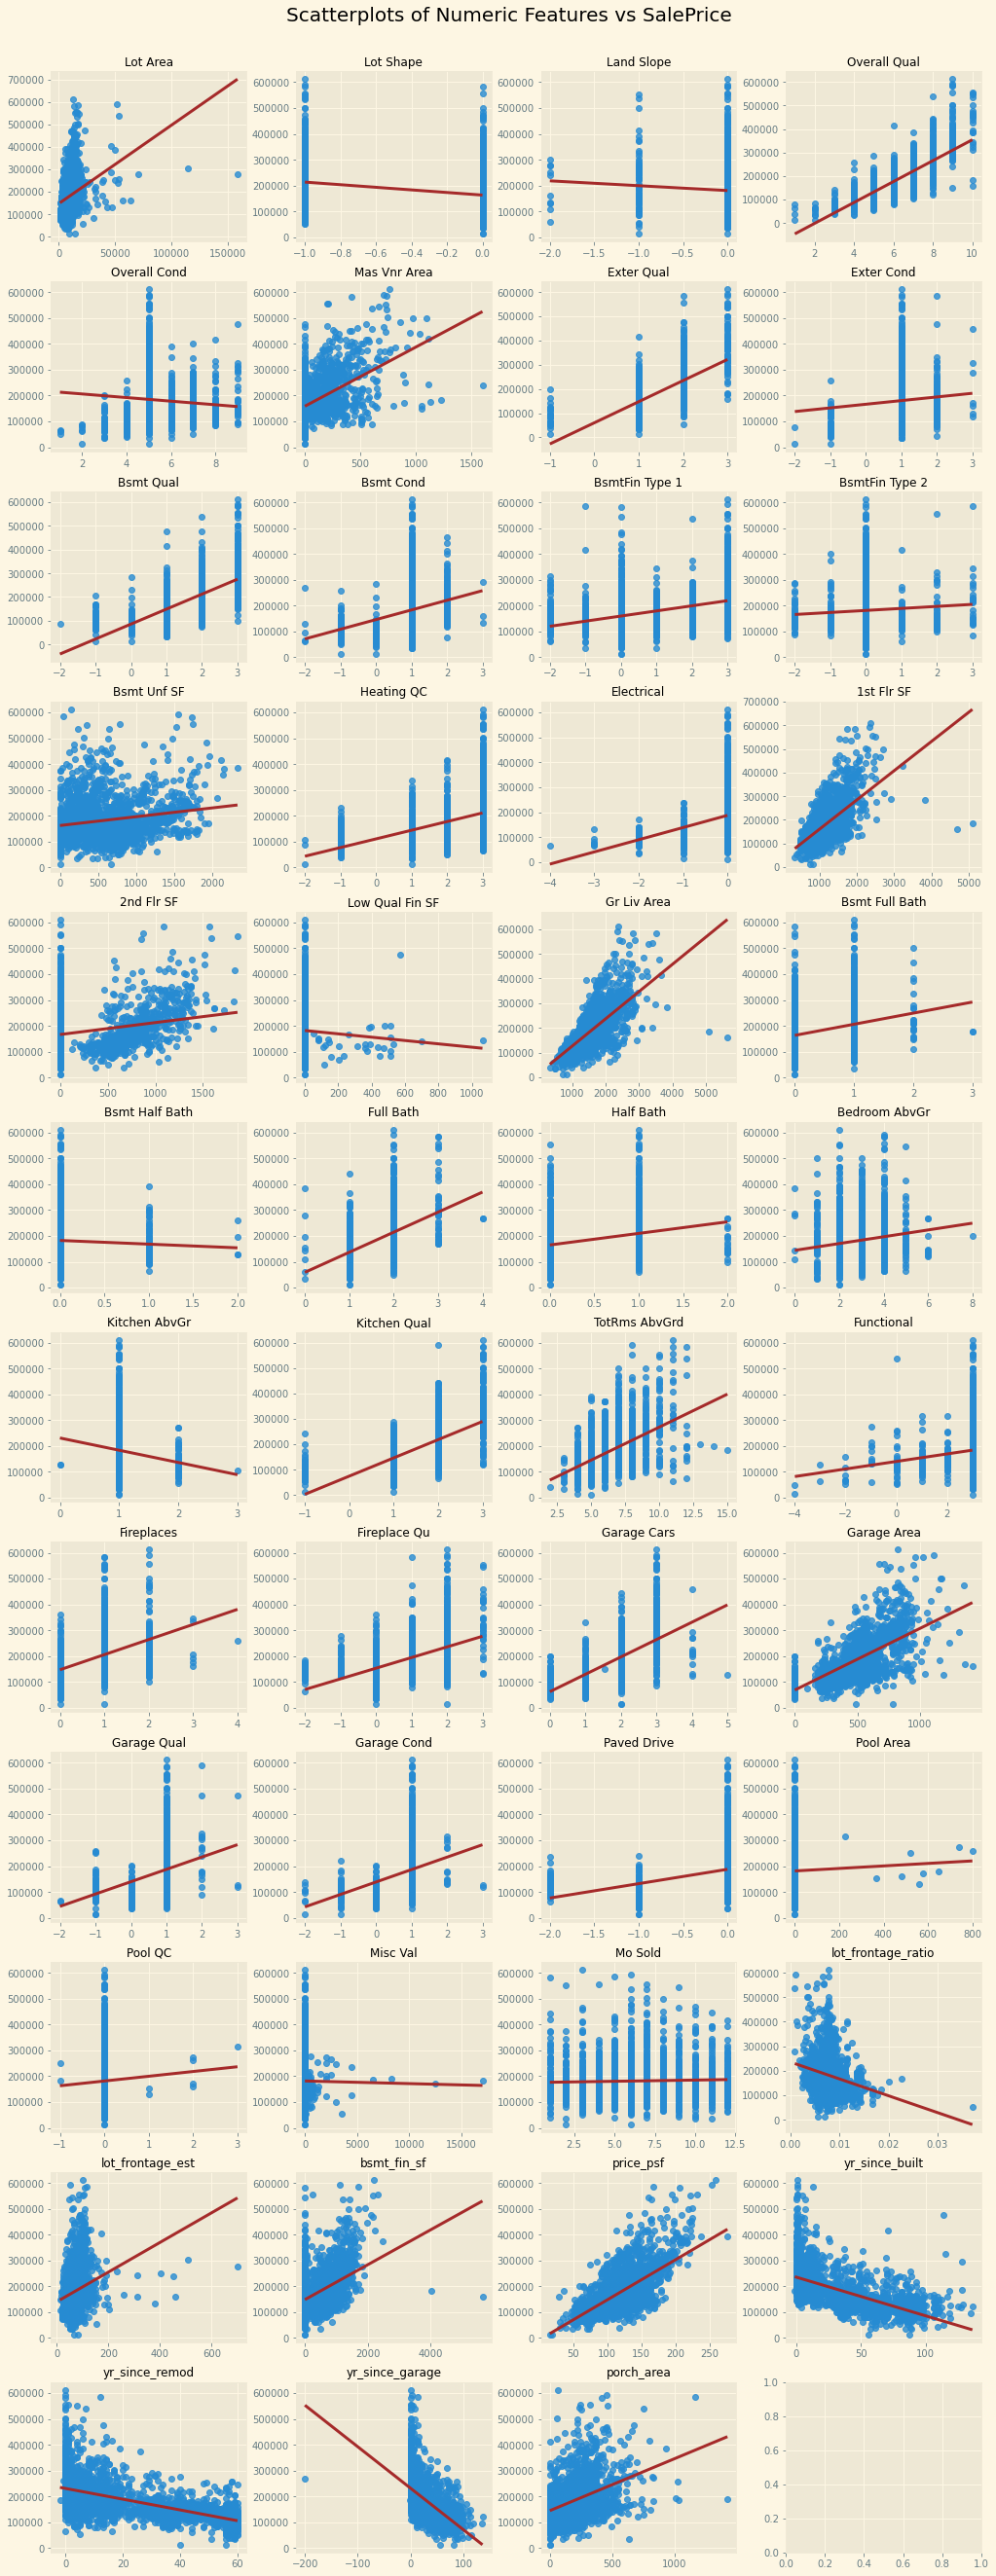

In [17]:
# Plot Scatterplots of Numeric Features vs Price per Square Foot (Gross Living Area)
rows = math.ceil(len(numerical_columns)/4)
cols = 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, rows*3))
plt.tight_layout(h_pad=2, w_pad=2)

ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    g = sns.regplot(data = df_train, x=column, y='SalePrice', ax=ax[i], 
                    ci=None, line_kws={'color': 'brown'})
    ax[i].set_title(column,fontsize=12)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
fig.suptitle('Scatterplots of Numeric Features vs SalePrice', 
             fontsize=20,y=1.02)  

**Area**

Most area related features have positive correlation with `SalePrice`, seemingly strongest of which is `Gr Liv Area`, which corroborates with the correlation factor that we saw earlier. We note a couple of outliers in `Gr Liv Area` of large properties that have significantly lower price compared to the main bulk of the datapoints so we will look into these below.

**Rooms**

As for features that pertain to number of rooms, they mostly do some correlation with `SalePrice`, but compared to area features they are not as strong and more heteroscedastic (i.e. having varying scatters along the range), hence these might not be as good as area features in predicting price.

**Age**

Age features also have negative correlation with price, the newer the property the higher the price. We note some outliers having negative age and we will investigate this further below.

**Quality & Condition**

Most quality & condition features have positive correlation with price.

#### Investigate Outliers

**Price & Area Outliers**

We note two outliers of large properties that have low price per square foot. Looking closer at the data in the table below, it has high overall quality and does not seem to be of unusual sale transaction type. Hence it is unusual as overall quality has a strong correlation with price.

One guess is that large properties have a price penalty after a certain size. As the test data have properties that are above 4000 sq ft which is above the norm of the train dataset, we will create a feature that indicates large properties that are 4000 sq ft and above.

Text(0.5, 1.0, 'Scatterplot of Gr Liv Area vs price_psf vs Overall Qual')

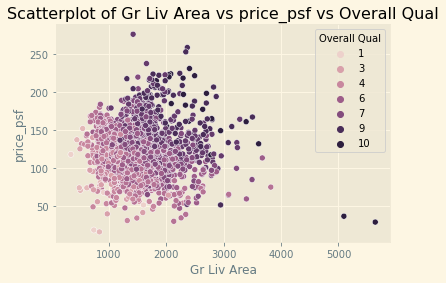

In [18]:
sns.scatterplot(data = df_train, x='Gr Liv Area', y='price_psf',
            hue='Overall Qual');
plt.title('Scatterplot of Gr Liv Area vs price_psf vs Overall Qual')

In [19]:
# Filter large properties above 4000 sq ft
df_combine.loc[(df_combine['Gr Liv Area']>4000),
               ['Gr Liv Area','SalePrice','price_psf','Overall Qual','Sale Type']]

Gr Liv Area  SalePrice  price_psf  Overall Qual Sale Type
train 960          5642   160000.0  28.358738            10       New
      1885         5095   183850.0  36.084396            10       New
test  170          4476        0.0   0.000000            10       WD 
      463          4316        0.0   0.000000            10       WD

In [20]:
def large_house(df):
    '''Adds a boolean feature for Gr Liv Area larger than 4000'''
    df['large_house'] = df['Gr Liv Area']>4000
large_house(df_combine)
numerical_columns.append('large_house')

**Age Outliers**

We noted some negative age in the calculated age features. We filter the data to isolate those rows as seen below. These seems to be erroneous as the year built/remod cant be later than the year sold. Hence we will assert the negative values to zero.

In [21]:
df_combine.loc[  
    (df_combine['yr_since_built'] <0)|
    (df_combine['yr_since_remod'] <0)|
    (df_combine['yr_since_garage'] <0), 
    ['yr_since_built', 'yr_since_remod','yr_since_garage',
     'Yr Sold', 'Year Built', 'Garage Yr Blt','Year Remod/Add']]

yr_since_built  yr_since_remod  yr_since_garage  Yr Sold  \
train 1699               1               0           -200.0     2007   
      1719               0              -1              0.0     2007   
      1885              -1              -2             -1.0     2007   

            Year Built  Garage Yr Blt  Year Remod/Add  
train 1699        2006         2207.0            2007  
      1719        2007         2007.0            2008  
      1885        2008         2008.0            2009

In [22]:
df_combine.loc[(df_combine['yr_since_built']<0),'yr_since_built'] = 0
df_combine.loc[(df_combine['yr_since_remod']<0),'yr_since_remod'] = 0
df_combine.loc[(df_combine['yr_since_garage']<0),'yr_since_garage'] = 0

Having cleaned and analyzed our numerical data, we now drop the features for which we have superceded with newly engineered ones.

Resplit data again due to changes

In [23]:
# drop columns that are replaced with new features
df_combine.drop(columns=['Yr Sold', 'Year Built', 'Garage Yr Blt','Year Remod/Add', 
                         'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                         '3Ssn Porch','Screen Porch'], inplace=True)

In [24]:
# split train and test data for analysis
df_train = df_combine.loc[('train')].copy()
df_test = df_combine.loc[('test')].copy()

In [28]:
# Create masks for categorical and numerical features
category_columns = [key for key, val in df_train.iteritems() 
                    if df_train.dtypes[key] == 'object']
numerical_columns = [key for key, val in df_train.iteritems() 
                     if (df_train.dtypes[key] == 'int64') or (df_train.dtypes[key] == 'float64')
                    or (df_train.dtypes[key] == 'bool')]
print(len(category_columns))
print(len(numerical_columns))

26
54


### EDA -  Categorical Features

In this section, we will plot a scatterplot of categorical features versus price per square feet (`Gr Liv Area`), since `Gr Liv Area` has one of the largest correlation to `SalePrice`, and by doing so we reduce the impact of `Gr Liv Area` on the variation within each category.

Text(0.5, 1.02, 'Scatterplots of Categorical Features vs SalePrice')

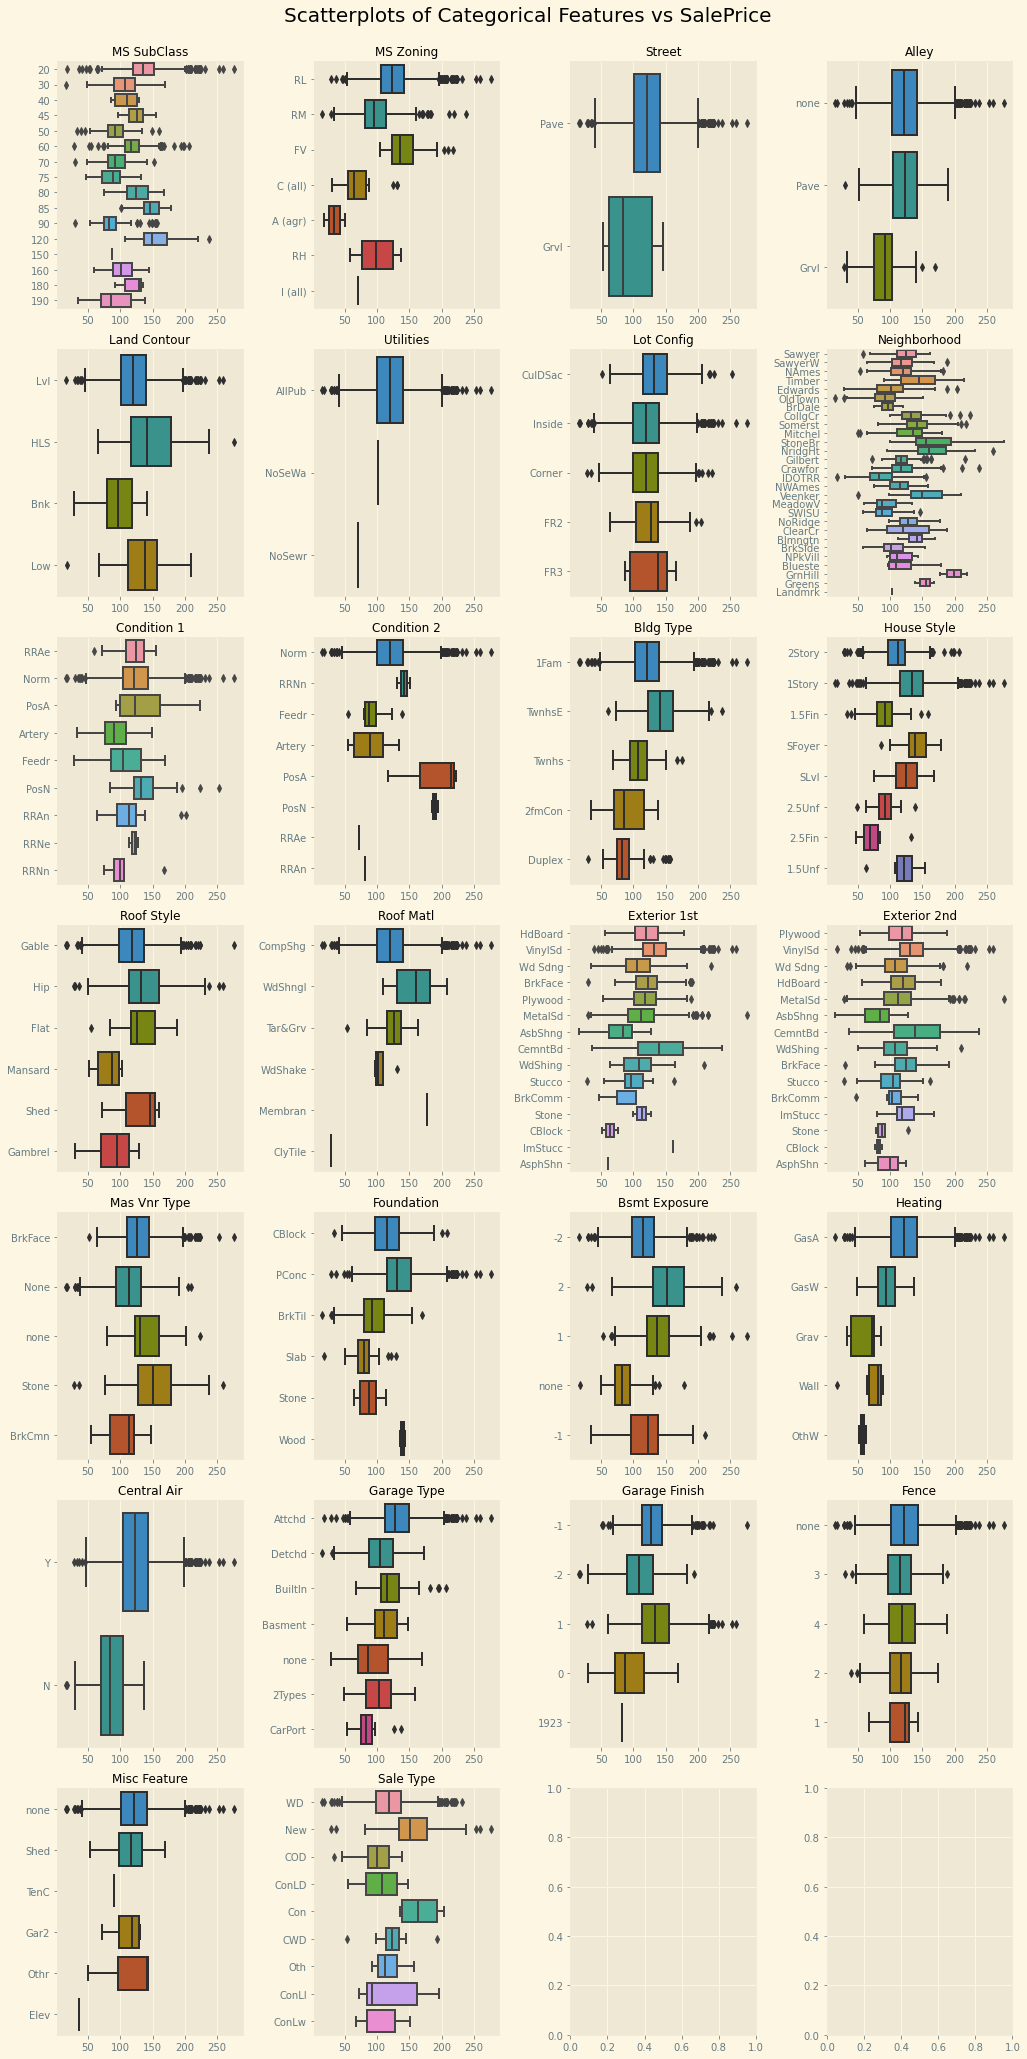

In [30]:
rows = round(len(category_columns)/4)+1
cols = 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, rows*4))
plt.tight_layout(h_pad=2, w_pad=4)

ax = ax.ravel()

for i, column in enumerate(category_columns):
    g = sns.boxplot(data = df_train, x='price_psf', y=column, ax=ax[i], orient='h')
    ax[i].set_title(column,fontsize=12)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
fig.suptitle('Scatterplots of Categorical Features vs SalePrice', 
             fontsize=20,y=1.02)  

We see that most categorical features have impact to price per square foot, except a few like `Lot Config`, `Fence`, and `Misc Features` where there there is less noticable variation between categories.

### Feature Selection

We will conduct feature selection with the priciple of reducing multicollinearity between features. Numerical features and Categorical features will be assessed seperately, while sharing similar high level methodology, with differences in the type of statistic used for each type. 

This is done to preserve the structure of categorical features as the aim of this study seeks to provide homeowners with guidance in upgrading their home, so as to see the relative impact to price of each individual category in the regression model.

High Level Methodology:
- Remove features with strong multicollinearity based on a correlation heatmap
- Followed by reducing pairwise correlation, keeping the feature that has higher correlation with `SalePrice` of the pair. 

Numerical Features: we would use the Pearson standard correlation coefficient.

Categorical Features: we would use Cramér's V to assess the category to category association between categorical features, and then calculate the One-way ANOVA statistic to assess how siginificant the impact the category sub-group has on `SalePrice`.

#### Feature Selection - Numerical Columns

In [31]:
def cluster_corr(corr_array, inplace=False):
    """
    https://wil.yegelwel.com/cluster-correlation-matrix/
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [32]:
#Add back SalePrice
numerical_columns = numerical_columns + ['SalePrice']

<AxesSubplot:>

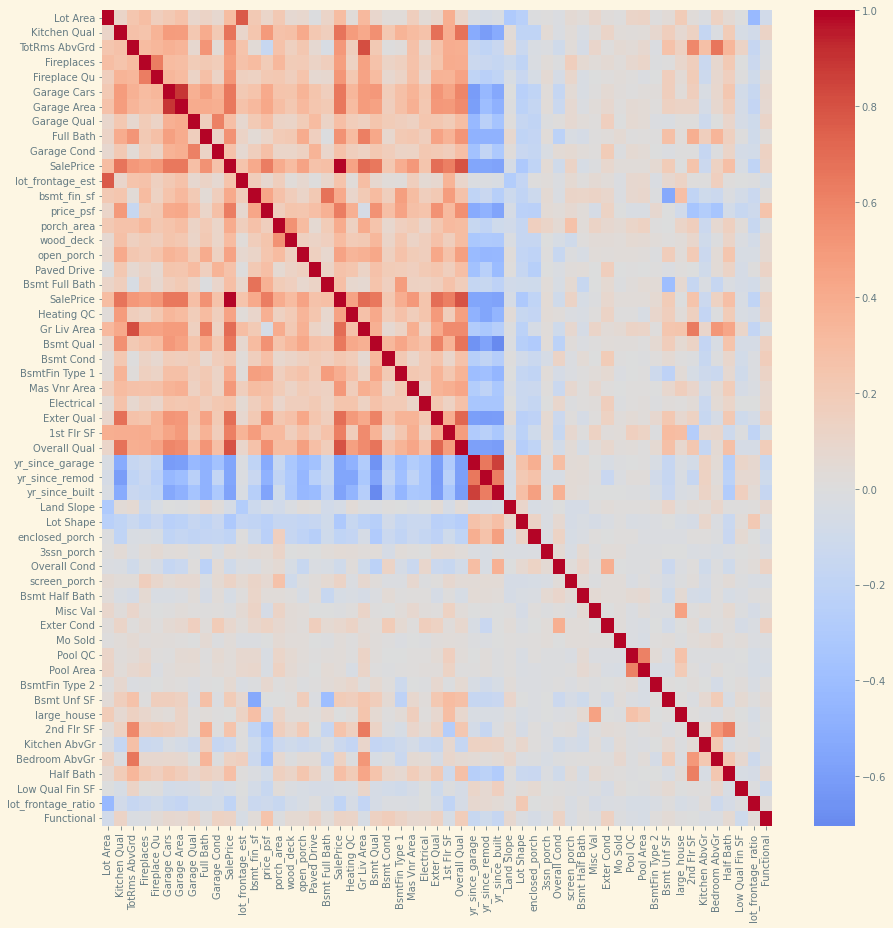

In [34]:
df_corr = df_train.loc[:,numerical_columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(cluster_corr(df_corr), annot=False, cmap='coolwarm', center=0)

We see that Quality and Area features are moderately to strongly correlated across many features Hence we would just keep `Overall Qual` and `Gr Liv Area` since these have the strongest correlation with `SalePrice`. We see this with `Full Bath`, `Garage Cars` as well.

As for Age related features, they are also strongly correlated with each other and negatively correlated across many features as well. Hence we would keep `yr_since_remod` since it is relevant to the problem statement.

In [35]:
print(numerical_columns)

['Lot Area', 'Lot Shape', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Unf SF', 'Heating QC', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool Area', 'Pool QC', 'Misc Val', 'Mo Sold', 'SalePrice', 'lot_frontage_ratio', 'lot_frontage_est', 'bsmt_fin_sf', 'price_psf', 'yr_since_built', 'yr_since_remod', 'yr_since_garage', 'porch_area', 'wood_deck', 'open_porch', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'large_house', 'SalePrice']


In [36]:
to_remove = ['Exter Qual','Bsmt Qual','Kitchen Qual', 
             '1st Flr SF', 'Garage Area',
             'Garage Cars', 'Full Bath',
             'yr_since_garage', 'yr_since_built','lot_frontage_ratio'
            ]

for i in to_remove:
    numerical_columns.remove(i)

Now we will do pairwise correlation analysis on the remaining features

In [37]:
# Create matrix of all feature correlations
corr_matrix = df_train[numerical_columns].corr().abs()

# Change shape of correlation matrix to narrow form
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                  .astype(bool))
                  .stack()
                  .sort_values(ascending=False))

# Convert to dataframe and reset multi-level index
corr_df = pd.DataFrame(sol).reset_index()

# Rename columns
corr_df.columns = 'v1', 'v2', 'pair_corr'

In [38]:
def corr_target(row):
    '''calculates pairwise correlation with SalePrice'''
    row['v1_y_corr'] = df_train.corr()['SalePrice'][row['v1']]
    row['v2_y_corr'] = df_train.corr()['SalePrice'][row['v2']]
    return row

In [39]:
# Create df with pairwise correlation and correlation to target
corr_df = corr_df.apply(corr_target, axis=1)
corr_df.head(24)

,v1,v2,pair_corr,v1_y_corr,v2_y_corr
0,SalePrice,SalePrice,1.000000,1.000000,1.000000
1,Gr Liv Area,TotRms AbvGrd,0.813333,0.697038,0.504014
2,Overall Qual,SalePrice,0.800207,0.800207,1.000000
3,Overall Qual,SalePrice,0.800207,0.800207,1.000000
4,Lot Area,lot_frontage_est,0.772405,0.296566,0.253076
5,Gr Liv Area,SalePrice,0.697038,0.697038,1.000000
6,Gr Liv Area,SalePrice,0.697038,0.697038,1.000000
7,Bsmt Full Bath,bsmt_fin_sf,0.671670,0.283332,0.411214
8,Bedroom AbvGr,TotRms AbvGrd,0.655439,0.137067,0.504014
9,2nd Flr SF,Gr Liv Area,0.639092,0.248452,0.697038


As many numerical columns are highly correlated with each other, we would drop features until most of the pairwise correlations is less than 0.5. For each pairwise match, the one with higher correlation with `SalePrice` will be kept. We would keep `Overall Qual` and `Gr Liv Area` as we have removed many quality and area related features in favor of these already.

In [40]:
to_remove = ['TotRms AbvGrd', 'SalePrice', 'lot_frontage_est', 'Bsmt Full Bath', 'Bedroom AbvGr',
             '2nd Flr SF', 'Fireplaces', 'Pool Area', 'Garage Cond', 'Bsmt Unf SF',
             'price_psf'
            ]
for i in to_remove:
    numerical_columns.remove(i)

In [41]:
# Create matrix of all feature correlations
corr_matrix = df_train[numerical_columns].corr().abs()

# Change shape of correlation matrix to narrow form
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                  .astype(bool))
                  .stack()
                  .sort_values(ascending=False))

# Convert to dataframe and reset multi-level index
corr_df = pd.DataFrame(sol).reset_index()

# Rename columns
corr_df.columns = 'v1', 'v2', 'pair_corr'

In [42]:
# Create df with pairwise correlation and correlation to target
corr_df = corr_df.apply(corr_target, axis=1)
corr_df.head(24)

,v1,v2,pair_corr,v1_y_corr,v2_y_corr
0,Overall Qual,SalePrice,0.800207,0.800207,1.000000
1,Gr Liv Area,SalePrice,0.697038,0.697038,1.000000
2,Overall Qual,yr_since_remod,0.585689,0.800207,-0.551736
3,Overall Qual,Gr Liv Area,0.566701,0.800207,0.697038
4,yr_since_remod,SalePrice,0.551736,-0.551736,1.000000
5,Heating QC,yr_since_remod,0.550794,0.446025,-0.551736
6,porch_area,wood_deck,0.536924,0.406338,0.311237
7,Fireplace Qu,SalePrice,0.510098,0.510098,1.000000
8,Mas Vnr Area,SalePrice,0.503579,0.503579,1.000000
9,BsmtFin Type 1,bsmt_fin_sf,0.471173,0.392434,0.411214


### Feature Selection - Categorical Variables

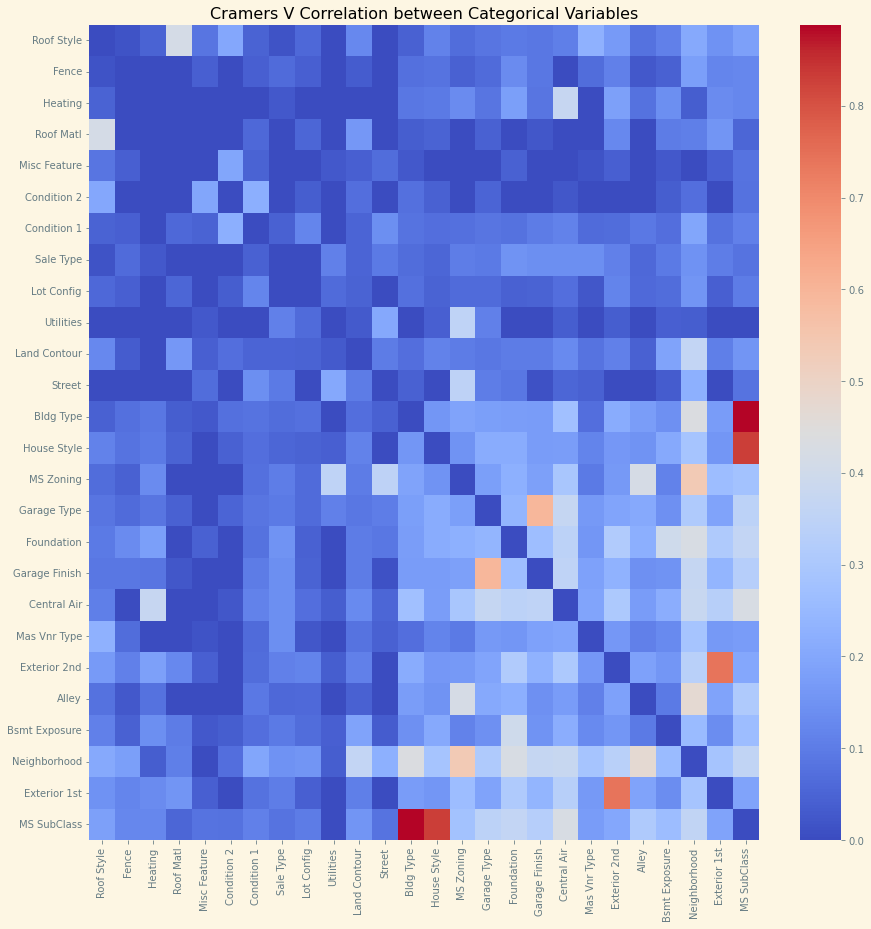

In [43]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
        Code adapted from https://www.kaggle.com/code/phaethonprime/
        eda-and-logistic-regression/notebook
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = category_columns
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_combine[col1], df_combine[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cluster_corr(corr), annot=False, ax=ax, cmap='coolwarm'); 
ax.set_title("Cramers V Correlation between Categorical Variables");

Our objective is to reduce mulitcollinearlity in our chosen features, while maximizing correlation with sales price

We note that `Neighborhood`, `MS Subclass`, `Central Air`, has moderate to strong correlation with many varibles, so we will exclude these.

We also see moderate to strong pairwise correlation between the following variables, we would pick the one that has higher variance and exclude the other.

| Col1 | Col2 |
| --- | --- |
| Roof Matl | Roof Style |
| Street | MS Zoning |
| Exterior 1st | Exterior 2nd |
| Garage Finish | Garage Type |

Then One-Way ANOVA statistics calculated to measure the variance between the values in each category with `price_psf`. Then we would select the top 12 categories for our regression model, after considering the findings from our pairwise correlation above.

In [44]:
d = []
for i in category_columns:
    F, p = ss.f_oneway(*[df_train[df_train[i]==j]['price_psf'].values for j in df_train[i].unique()])
    d.append((i,F,p))
f_stat_sorted = pd.DataFrame(d, columns = ['category', 'f stat', 'p value']) \
                .sort_values(by='f stat', ascending=False)
display(f_stat_sorted)

,category,f stat,p value
20,Central Air,205.982932,1.390459e-44
18,Bsmt Exposure,131.415172,5.374250e-100
22,Garage Finish,118.521944,4.952221e-91
17,Foundation,108.699610,5.245244e-102
11,House Style,83.457076,6.334936e-107
16,Mas Vnr Type,81.678231,2.150266e-64
0,MS SubClass,77.336702,1.231109e-186
21,Garage Type,70.216796,1.021245e-79
10,Bldg Type,53.735129,4.083380e-43
7,Neighborhood,51.143384,7.928342e-206


In [45]:
print(list(f_stat_sorted['category'].values))

['Central Air', 'Bsmt Exposure', 'Garage Finish', 'Foundation', 'House Style', 'Mas Vnr Type', 'MS SubClass', 'Garage Type', 'Bldg Type', 'Neighborhood', 'MS Zoning', 'Alley', 'Land Contour', 'Sale Type', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Heating', 'Condition 1', 'Lot Config', 'Condition 2', 'Fence', 'Street', 'Roof Matl', 'Misc Feature', 'Utilities']


Here are the categories variables selected

In [46]:
selected_cats = ['Bsmt Exposure', 'Garage Finish', 'Foundation', 'House Style', 
                'Mas Vnr Type', 'Bldg Type', 'MS Zoning', 'Alley', 
                'Land Contour', 'Sale Type','Roof Style', 'Exterior 1st']

#### Export Data

In [49]:
col_slice = numerical_columns + selected_cats

In [51]:
df_combine[col_slice].to_csv('../project_2/datasets/df_processed.csv')